In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report,roc_curve, auc
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import LearningCurveDisplay

In [ ]:

# fetch dataset
X, y= load_wine(as_frame=True, return_X_y=True)
df= pd.concat([X, y], axis=1)
target_labels= df["target"].unique()
pd.set_option("display.max_columns", None)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [ ]:
def print_report(y_true, ypred, model_name):
  print('-'*30)
  print(f"Model: {model_name}")
  print('-'*30)
  print("Confusion Matrix: ")
  print(confusion_matrix(y_true, ypred))

  print('-'*30)
  print(f"Accuracy_score: {accuracy_score(y_true, ypred)}")
  print("-"*30)
  print(f"Recall_score: {recall_score(y_true, ypred, average='macro')}")
  print('-'* 30)
  print(f"Precision_score: {precision_score(y_true, ypred, average='macro')}")
  print('-'* 30)
  print(f"F1_score: {f1_score(y_true, ypred, average='macro')}")
  print('-'*30)
  print("Classification Report: ")
  print(classification_report(y_true, ypred))
  print('-'*30)


def plot_multiclass_roc(y_true, y_pred_proba, model_name, n_classes=3):
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    #fig, axes= plt.subplots(nrows=1, ncols= 3, figsize= (15, 6))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(5, 4))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')


    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_test, y_pred, labels):
  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels, )
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()

def plot_learning_curve(estimator, x, y):
  LearningCurveDisplay.from_estimator(
      estimator,
      x,
      y
  )

  plt.show()

In [ ]:
df.shape

(178, 14)

In [ ]:
df.isnull().sum()

,0
alcohol,0
malic_acid,0
ash,0
alcalinity_of_ash,0
magnesium,0
total_phenols,0
flavanoids,0
nonflavanoid_phenols,0
proanthocyanins,0
color_intensity,0


In [ ]:
df.duplicated().sum().sum()

np.int64(0)

In [ ]:
y= df["target"]
x= df.drop(["target"], axis=1)


In [ ]:
scaler= StandardScaler()
x_scaled= scaler.fit_transform(x)

In [ ]:
def get_accuracy_scores(x, y, split_list):
    accuracy_scores = {
        'Random Forest': [],
        'SVC': [],
        'MLP': []
    }
    for split in split_list:
        xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=split, random_state=42)

        # Random Forest
        rf = RandomForestClassifier()
        rf.fit(xtrain, ytrain)
        accuracy_scores['Random Forest'].append(accuracy_score(ytest, rf.predict(xtest)))

        # SVC
        svc = SVC()
        svc.fit(xtrain, ytrain)
        accuracy_scores['SVC'].append(accuracy_score(ytest, svc.predict(xtest)))

        # MLP
        mlp = MLPClassifier(max_iter=200, learning_rate="adaptive", momentum=0.9, early_stopping=True)
        mlp.fit(xtrain, ytrain)
        accuracy_scores['MLP'].append(accuracy_score(ytest, mlp.predict(xtest)))

    return accuracy_scores

def plot_accuracy_vs_test_size(accuracy_scores, split_list):
    plt.figure(figsize=(8, 5))
    for model_name, scores in accuracy_scores.items():
        plt.plot(split_list, scores, marker='o', label=model_name)

    plt.xlabel('Test Size')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracy vs. Test Size for Different Models')
    plt.legend()
    plt.grid(True)
    plt.show()

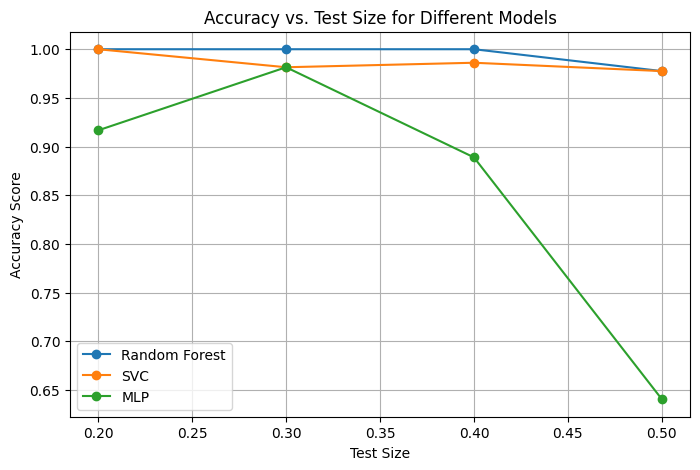

In [ ]:
score_metrics= get_accuracy_scores(x_scaled, y, [0.2, 0.3, 0.4, 0.5])
plot_accuracy_vs_test_size(score_metrics, [0.2, 0.3, 0.4, 0.5])

In [ ]:
def rf_train_and_plot(x, y, split):
  xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size= split, random_state= 42)
  rf= RandomForestClassifier()
  rf.fit(xtrain, ytrain)

  ypred_rf= rf.predict(xtest)
  ypred_rf_proba= rf.predict_proba(xtest)

  print_report(ytest, ypred_rf, "Random Forest Classifier")
  plot_confusion_matrix(ytest, ypred_rf, target_labels)
  plot_multiclass_roc(ytest, ypred_rf_proba, "Random Forest Classifier")
  #plot_learning_curve(rf, xtrain, ytrain)

def svc_train_and_plot(x, y, split):
  xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size= split, random_state= 42)
  svc= SVC(probability= True)
  svc.fit(xtrain, ytrain)

  ypred_svc= svc.predict(xtest)
  ypred_svc_proba= svc.predict_proba(xtest)
  print_report(ytest, ypred_svc, "SVC Classifier")
  plot_confusion_matrix(ytest, ypred_svc, target_labels)
  plot_multiclass_roc(ytest, ypred_svc_proba, "SVC Classifier")
  #plot_learning_curve(svc, xtrain, ytrain)

def mlp_train_and_plot(x, y, split):
  xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size= split, random_state= 42)
  mlp= MLPClassifier(max_iter=200, learning_rate= "adaptive", momentum= 0.9, early_stopping=True)
  mlp.fit(xtrain, ytrain)

  ypred_mlp= mlp.predict(xtest)
  ypred_mlp_proba= mlp.predict_proba(xtest)
  print_report(ytest, ypred_mlp, "MLP Classifier")
  plot_confusion_matrix(ytest, ypred_mlp, target_labels)
  plot_multiclass_roc(ytest, ypred_mlp_proba, "MLP Classifier")
  plot_learning_curve(mlp, xtrain, ytrain)

  # plotting the loss curve
  plt.plot(mlp.loss_curve_)
  plt.title("MLP Classifier Loss Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

------------------------------
Model: Random Forest Classifier
------------------------------
Confusion Matrix: 
[[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]
------------------------------
Accuracy_score: 1.0
------------------------------
Recall_score: 1.0
------------------------------
Precision_score: 1.0
------------------------------
F1_score: 1.0
------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

------------------------------


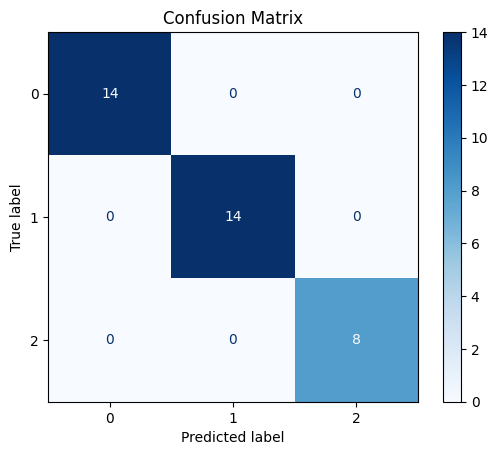

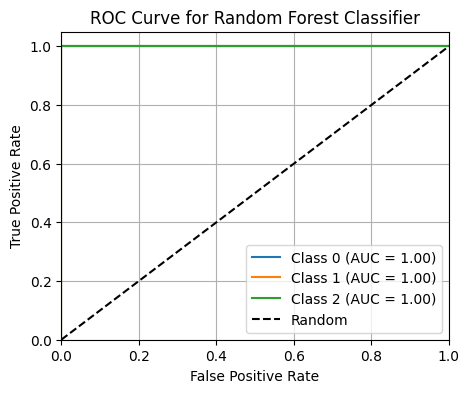

In [ ]:
rf_train_and_plot(x_scaled, y, 0.2)

------------------------------
Model: SVC Classifier
------------------------------
Confusion Matrix: 
[[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]
------------------------------
Accuracy_score: 1.0
------------------------------
Recall_score: 1.0
------------------------------
Precision_score: 1.0
------------------------------
F1_score: 1.0
------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

------------------------------


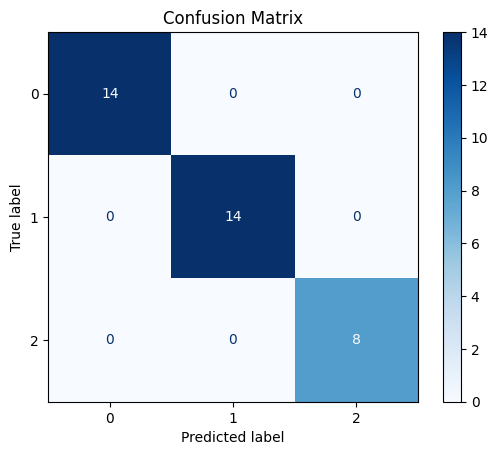

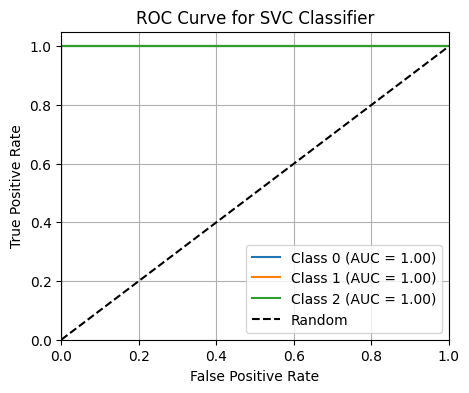

In [ ]:
svc_train_and_plot(x_scaled, y, 0.2)

------------------------------
Model: MLP Classifier
------------------------------
Confusion Matrix: 
[[14  5  0]
 [ 0 18  3]
 [ 3  0 11]]
------------------------------
Accuracy_score: 0.7962962962962963
------------------------------
Recall_score: 0.793233082706767
------------------------------
Precision_score: 0.7972841310437219
------------------------------
F1_score: 0.7938912938912939
------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        19
           1       0.78      0.86      0.82        21
           2       0.79      0.79      0.79        14

    accuracy                           0.80        54
   macro avg       0.80      0.79      0.79        54
weighted avg       0.80      0.80      0.80        54

------------------------------


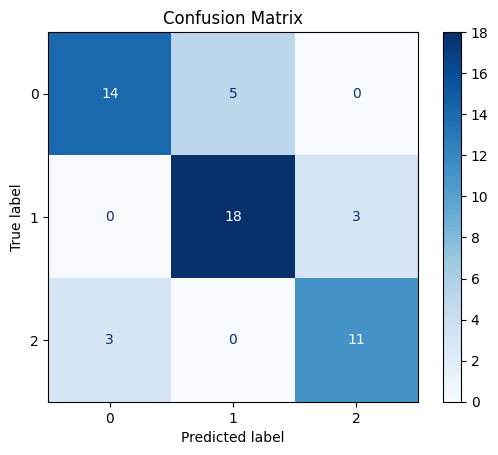

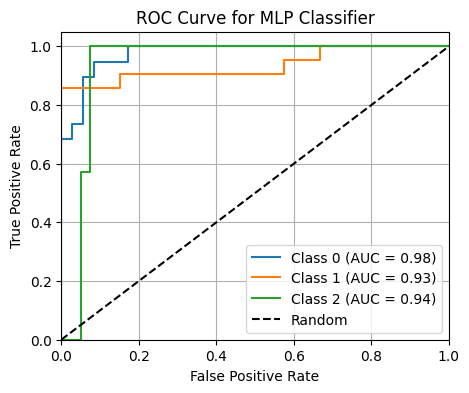

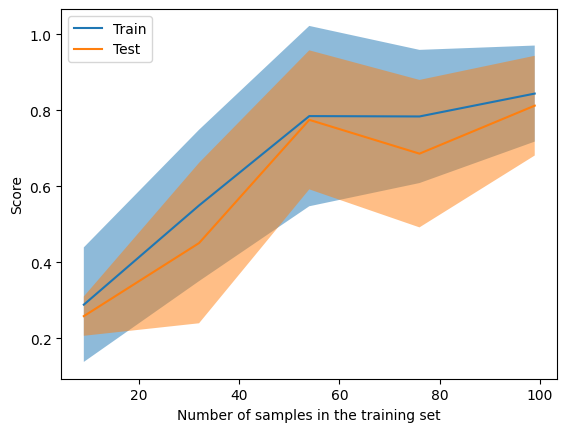

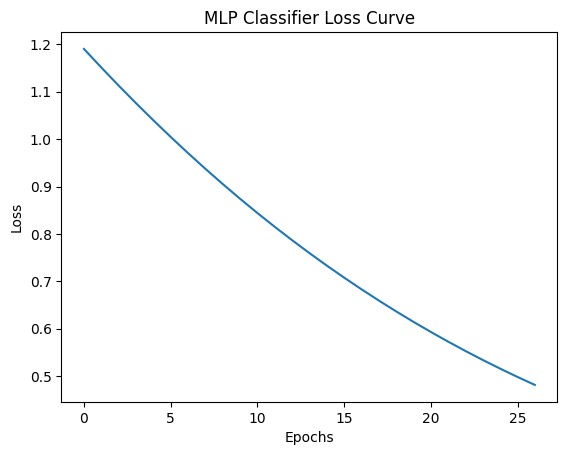

In [ ]:
mlp_train_and_plot(x_scaled, y, 0.3)

In [ ]:
pca= PCA(n_components= 0.95)
x_pca= pca.fit_transform(x_scaled)

In [ ]:
pca_xtrain, pca_xtest, pca_ytrain, pca_ytest= train_test_split(x_pca, y, test_size=0.2, random_state=42)

In [ ]:
def rf_train_and_plot_pca(x, y, split):
  xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size= split, random_state= 42)
  rf_classifier= RandomForestClassifier(
    n_estimators= 40,
    ccp_alpha= 0.9,
    max_depth=10,
    min_samples_leaf=5
  )
  rf_classifier.fit(xtrain, ytrain)

  ypred_rf= rf_classifier.predict(xtest)
  ypred_rf_proba= rf_classifier.predict_proba(xtest)
  print_report(ytest, ypred_rf, "Random Forest Classifier with PCA")
  plot_confusion_matrix(ytest, ypred_rf, target_labels)
  plot_multiclass_roc(ytest, ypred_rf_proba, "Random Forest Classifier with PCA")
  #plot_learning_curve(rf_classifier, xtrain, ytrain)

def svc_train_and_plot_pca(x, y, split):
  xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size= split, random_state= 42)
  svc_classifier= SVC(
    kernel= "linear",
    probability= True
  )

  svc_classifier.fit(xtrain, ytrain)
  ypred_svc= svc_classifier.predict(xtest)
  ypred_svc_proba= svc_classifier.predict_proba(xtest)
  print_report(ytest, ypred_svc, "SVC Classifier with PCA")
  plot_confusion_matrix(ytest, ypred_svc, target_labels)
  plot_multiclass_roc(ytest, ypred_svc_proba, "SVC Classifier with PCA")
  #plot_learning_curve(svc_classifier, xtrain, ytrain)

def mlp_train_and_plot_pca(x, y, split):
  xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size= split, random_state= 42)
  mlp_classifier= MLPClassifier(max_iter=200, learning_rate= "adaptive", momentum= 0.9, early_stopping=True)
  mlp_classifier.fit(xtrain, ytrain)
  ypred_mlp= mlp_classifier.predict(xtest)
  ypred_mlp_proba= mlp_classifier.predict_proba(xtest)
  print_report(ytest, ypred_mlp, "MLP Classifier with PCA")
  plot_confusion_matrix(ytest, ypred_mlp, target_labels)
  plot_multiclass_roc(ytest, ypred_mlp_proba, "MLP Classifier with PCA")
  plot_learning_curve(mlp_classifier, xtrain, ytrain)

  # plotting the loss curve
  plt.plot(mlp_classifier.loss_curve_)
  plt.title("MLP Classifier Loss Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

------------------------------
Model: Random Forest Classifier
------------------------------
Confusion Matrix: 
[[18  1  0]
 [ 1 20  0]
 [ 0  0 14]]
------------------------------
Accuracy_score: 0.9629629629629629
------------------------------
Recall_score: 0.9665831244778613
------------------------------
Precision_score: 0.9665831244778613
------------------------------
F1_score: 0.9665831244778613
------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.95      0.95      0.95        21
           2       1.00      1.00      1.00        14

    accuracy                           0.96        54
   macro avg       0.97      0.97      0.97        54
weighted avg       0.96      0.96      0.96        54

------------------------------


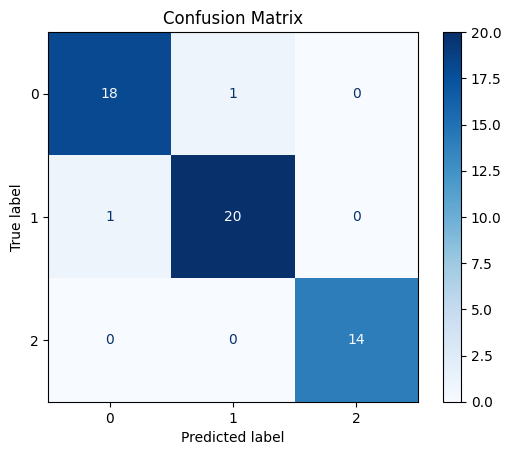

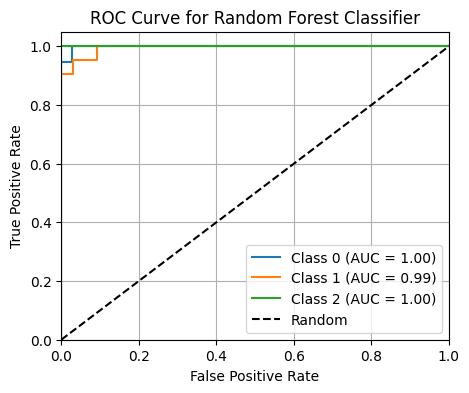

In [ ]:
rf_train_and_plot(x_pca, y, 0.3)

------------------------------
Model: SVC Classifier
------------------------------
Confusion Matrix: 
[[19  0  0]
 [ 0 21  0]
 [ 0  1 13]]
------------------------------
Accuracy_score: 0.9814814814814815
------------------------------
Recall_score: 0.9761904761904763
------------------------------
Precision_score: 0.9848484848484849
------------------------------
F1_score: 0.9799023830031581
------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.95      1.00      0.98        21
           2       1.00      0.93      0.96        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

------------------------------


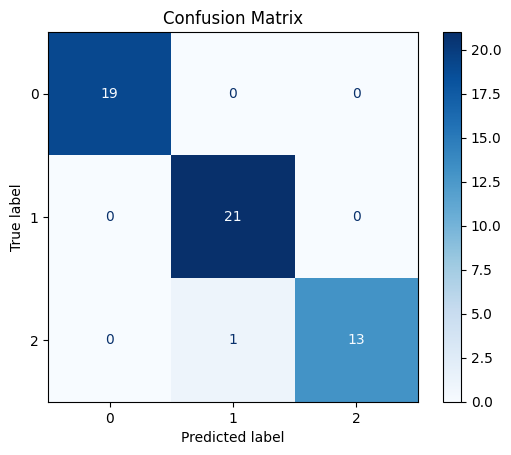

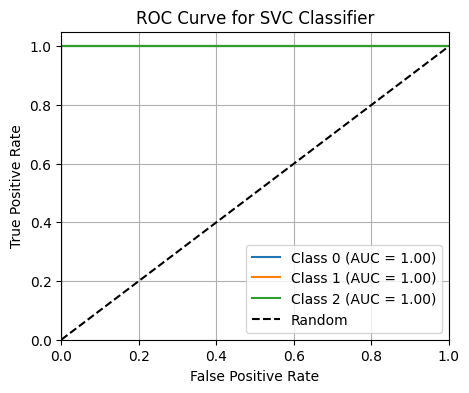

In [ ]:
svc_train_and_plot(x_pca, y, 0.3)

------------------------------
Model: MLP Classifier
------------------------------
Confusion Matrix: 
[[16  3  0]
 [ 0 20  1]
 [ 0  0 14]]
------------------------------
Accuracy_score: 0.9259259259259259
------------------------------
Recall_score: 0.9314954051796157
------------------------------
Precision_score: 0.9342995169082124
------------------------------
F1_score: 0.9296312882519779
------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        19
           1       0.87      0.95      0.91        21
           2       0.93      1.00      0.97        14

    accuracy                           0.93        54
   macro avg       0.93      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54

------------------------------


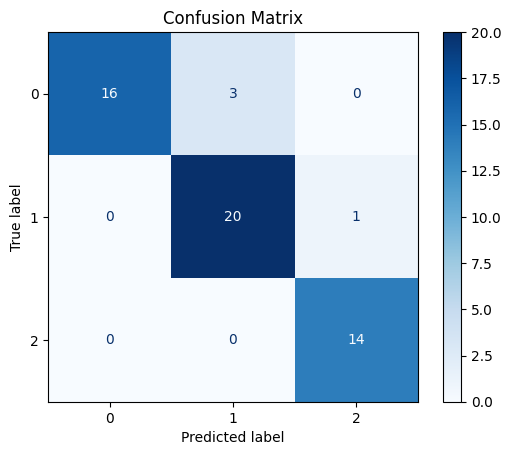

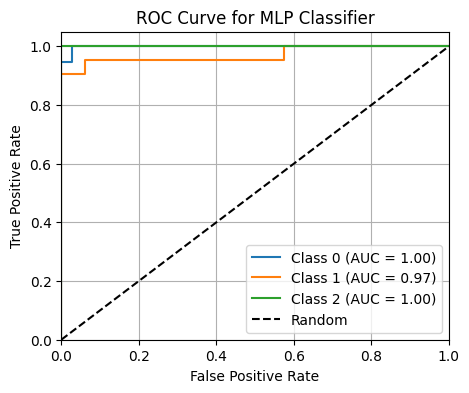

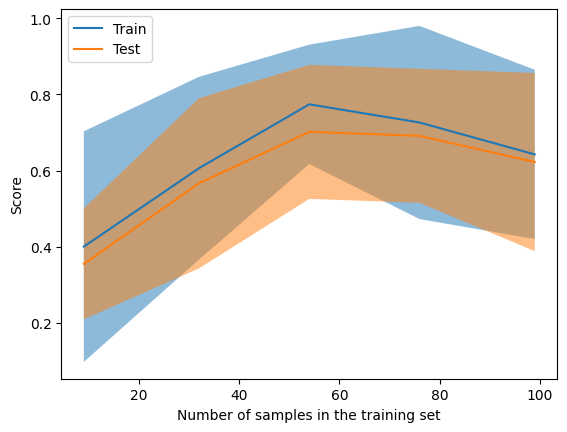

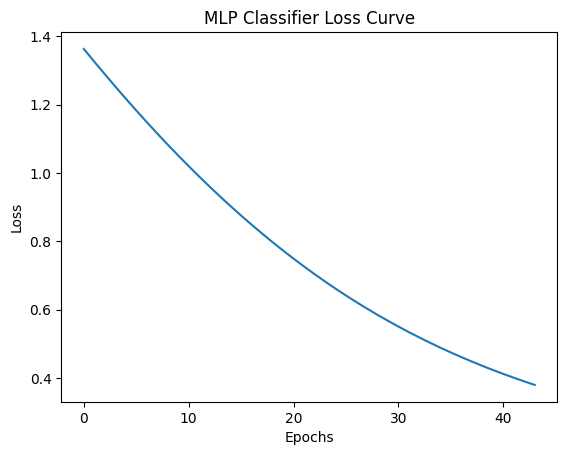

In [ ]:
mlp_train_and_plot(x_pca, y, 0.3)